In [ ]:
%run PNe_fitting

In [1]:
gal_name = "FCC167"

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Ellipse, Circle
from astropy.io import ascii, fits
from astropy.wcs import WCS, utils, wcs
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
#from astropy.stats import knuth_bin_width, histogram, bayesian_blocks
from lmfit import minimize, Minimizer, report_fit, Model, Parameters
import lmfit
import pandas as pd
from photutils import CircularAperture
from IPython.display import display
from MUSE_Models import PNe_residuals_3D, PNe_spectrum_extractor, PNextractor, PSF_residuals_3D, data_cube_y_x
import yaml
import sep
from photutils import CircularAperture
import scipy as sp
from scipy.stats import norm
from scipy import stats

%config InlineBackend.figure_format = 'retina'

In [3]:
# functions
# Open Fits file and assign to raw_data
# 

# if gal_name == "FCC167":
#     hdulist = fits.open("FCC167_data/FCC167_emission_cube.fits")
#     hdr = hdulist[0].header
#     wavelength = np.load(gal_name+"_data/"+gal_name+"_wavelength.npy")
# else:
#     hdulist = fits.open(gal_name+"_data/"+gal_name+"_residuals_list.fits")
#     hdr = hdulist[0].header
#     wavelength = np.exp(hdulist[1].data)

hdulist = fits.open(gal_name+"_data/"+gal_name+"_residuals_list.fits")
hdr = hdulist[0].header
wavelength = np.exp(hdulist[1].data)

if gal_name == "FCC219":
    x_data, y_data, n_data = data_cube_y_x(len(hdulist[0].data))
else:
    y_data, x_data, n_data = data_cube_y_x(len(hdulist[0].data))
    
    
n_pixels = 9    # minicube FOV in pixels
c = 299792458.0 # speed of light

coordinates = [(n,m) for n in range(n_pixels) for m in range(n_pixels)]
x_fit = np.array([item[0] for item in coordinates])
y_fit = np.array([item[1] for item in coordinates])

# Retrieve the respective spectra for each PNe source

In [4]:
x_y_list = np.load("exported_data/"+gal_name+"/PNe_x_y_list.npy")
x_PNe = np.array([x[0] for x in x_y_list])
y_PNe = np.array([y[1] for y in x_y_list])

PNe_spectra = np.array([PNe_spectrum_extractor(x, y, n_pixels, hdulist[0].data, x_data, wave=wavelength) for x,y in zip(x_PNe, y_PNe)])

PNe_df = pd.DataFrame(columns=("PNe number", "Ra (J2000)", "Dec (J2000)", "V (km/s)", "m 5007", "M 5007", "M 5007 error","A/rN", "rad D", "redchi", "Filter"))
PNe_df["PNe number"] = np.arange(0,len(x_PNe)) # PNe numbers
PNe_df["Filter"] = "Y"

# Objective Residual Cube
obj_residual_cube = fits.open("exported_data/"+gal_name+"/resids_obj.fits")

# Data Residual Cube
data_residual_cube = fits.open("exported_data/"+gal_name+"/resids_data.fits")


def uncertainty_cube_construct(data, x_P, y_P, n_pix):
    data[data == np.inf] = 0.01
    extract_data = np.array([PNe_spectrum_extractor(x, y, n_pix, data, x_data, wave=wavelength) for x,y in zip(x_P, y_P)])
    array_to_fill = np.zeros((len(x_P), n_pix*n_pix, len(wavelength)))
    for p in np.arange(0, len(x_P)):
        list_of_std = np.abs(np.std(extract_data[p],1))
        array_to_fill[p] = [np.repeat(list_of_std[i], len(wavelength)) for i in np.arange(0, len(list_of_std))]
  
    return array_to_fill

error_cube = uncertainty_cube_construct(data_residual_cube[0].data, x_PNe, y_PNe, n_pixels)
obj_error_cube = uncertainty_cube_construct(obj_residual_cube[0].data, x_PNe, y_PNe, n_pixels)

In [5]:
with open("galaxy_info.yaml", "r") as yaml_data:
    galaxy_info = yaml.load(yaml_data)
    
galaxy_data = galaxy_info[gal_name]

emission_dict = galaxy_data["emissions"]

D = galaxy_data["Distance"]

z = galaxy_data["z"]

In [6]:
PNe_multi_params = Parameters()

def gen_params(wave=5007, FWHM=4.0, FWHM_err=0.1, beta=2.5, beta_err=0.3, LSF=2.81, em_dict=None, vary_LSF=False, vary_PSF=False):
    # loop through emission dictionary to add different element parameters 
    for em in em_dict:
        #Amplitude params for each emission
        PNe_multi_params.add('Amp_2D_{}'.format(em), value=emission_dict[em][0], min=0.001, max=1e5, expr=emission_dict[em][1])
        #Wavelength params for each emission
        if emission_dict[em][2] == None:
            PNe_multi_params.add("wave_{}".format(em), value=wave, min=wave-60., max=wave+60.)
        else:
            PNe_multi_params.add("wave_{}".format(em), expr=emission_dict[em][2].format(z))
    
    PNe_multi_params.add("x_0", value=((n_pixels//2.) +1), min=0.1, max=n_pixels)
    PNe_multi_params.add("y_0", value=((n_pixels//2.) +1), min=0.1, max=n_pixels)
    PNe_multi_params.add("LSF", value=LSF, vary=vary_LSF) #min=LSF-0.2, max=LSF+0.2,
    PNe_multi_params.add("M_FWHM", value=FWHM, min=FWHM - FWHM_err, max=FWHM + FWHM_err, vary=vary_PSF)
    PNe_multi_params.add("beta", value=beta,  min=beta - beta_err, max=beta + beta_err, vary=vary_PSF)   
    PNe_multi_params.add("Gauss_bkg",  value=0.0001, min=-200, max=500)
    PNe_multi_params.add("Gauss_grad", value=0.0001, min=-2, max=2)
    
# storage setup
total_Flux = np.zeros((len(x_PNe),len(emission_dict)))
A_2D_list = np.zeros((len(x_PNe),len(emission_dict)))
F_xy_list = np.zeros((len(x_PNe), len(emission_dict), len(PNe_spectra[0])))
emission_amp_list = np.zeros((len(x_PNe),len(emission_dict)))
model_spectra_list = np.zeros((len(x_PNe), n_pixels*n_pixels, len(wavelength)))
mean_wave_list = np.zeros((len(x_PNe),len(emission_dict)))
residuals_list = np.zeros(len(x_PNe))
list_of_fit_residuals = np.zeros((len(x_PNe), n_pixels*n_pixels, len(wavelength)))
chi_2_r = np.zeros((len(x_PNe)))

# error lists
moff_A_err = np.zeros((len(x_PNe), len(emission_dict)))
x_0_err = np.zeros((len(x_PNe), len(emission_dict)))
y_0_err = np.zeros((len(x_PNe), len(emission_dict)))
mean_wave_err = np.zeros((len(x_PNe), len(emission_dict)))
Gauss_bkg_err = np.zeros((len(x_PNe), len(emission_dict)))
Gauss_grad_err = np.zeros((len(x_PNe), len(emission_dict)))

FWHM_list = np.zeros(len(x_PNe))
list_of_x = np.zeros(len(x_PNe))
list_of_y = np.zeros(len(x_PNe))
Gauss_bkg = np.zeros(len(x_PNe))
Gauss_grad = np.zeros(len(x_PNe))


def log_10(x):
    return np.log10(x)

def run_minimiser(parameters):
    for PNe_num in np.arange(138,139):#0, len(x_PNe)):
        useful_stuff = []        
        PNe_minimizer     = lmfit.Minimizer(PNe_residuals_3D,PNe_multi_params, fcn_args=(wavelength, x_fit, y_fit, PNe_spectra[PNe_num], error_cube[PNe_num], PNe_num, emission_dict, useful_stuff), nan_policy="propagate")
        multi_fit_results = PNe_minimizer.minimize()
        total_Flux[PNe_num] = np.sum(useful_stuff[1][1],1) * 1e-20
        list_of_fit_residuals[PNe_num] = useful_stuff[0]
        A_2D_list[PNe_num]  = useful_stuff[1][0]
        F_xy_list[PNe_num]  = useful_stuff[1][1]
        model_spectra_list[PNe_num] = useful_stuff[1][3]
        emission_amp_list[PNe_num]  = [multi_fit_results.params["Amp_2D_{}".format(em)] for em in emission_dict]
        mean_wave_list[PNe_num]     = [multi_fit_results.params["wave_{}".format(em)] for em in emission_dict]   
        chi_2_r[PNe_num]    = multi_fit_results.redchi
        list_of_x[PNe_num]  = multi_fit_results.params["x_0"]
        list_of_y[PNe_num]  = multi_fit_results.params["y_0"]
        Gauss_bkg[PNe_num]  = multi_fit_results.params["Gauss_bkg"]
        Gauss_grad[PNe_num] = multi_fit_results.params["Gauss_grad"]
        #save errors
        moff_A_err[PNe_num]     = [multi_fit_results.params["Amp_2D_{}".format(em)].stderr for em in emission_dict]
        mean_wave_err[PNe_num]  = [multi_fit_results.params["wave_{}".format(em)].stderr for em in emission_dict]
        x_0_err[PNe_num]        = multi_fit_results.params["x_0"].stderr
        y_0_err[PNe_num]        = multi_fit_results.params["y_0"].stderr
        Gauss_bkg_err[PNe_num]  = multi_fit_results.params["Gauss_bkg"].stderr
        Gauss_grad_err[PNe_num] = multi_fit_results.params["Gauss_grad"].stderr

    # Signal to noise and Magnitude calculations
    list_of_rN = np.array([np.std(PNe_res) for PNe_res in list_of_fit_residuals])
    PNe_df["A/rN"] = A_2D_list[:,0] / list_of_rN # Using OIII amplitude

    de_z_means = np.array(mean_wave_list[:,0] / (1 + z)) # de redshift OIII wavelength position
    
    PNe_df["V (km/s)"] = (c * (de_z_means - 5007.) / 5007.) / 1000.    
    
    PNe_df["redchi"] = chi_2_r
    
    PNe_df["[OIII] Flux"] = total_Flux[:,0] #store total OIII 5007 line flux
    
    PNe_df["[OIII]/Hb"] = PNe_df["[OIII] Flux"] / total_Flux[:,2] # store OIII/Hb ratio
    
    if "hb" in emission_dict:
        PNe_df["[OIII]/Hb"] = PNe_df["[OIII] Flux"] / total_Flux[:,2] # store [OIII]/Hb ratio

    if "ha" in emission_dict:
        PNe_df["Ha Flux"] = total_Flux[:, 1]
    
    def log_10(x):
        return np.log10(x)
    
    PNe_df["m 5007"] = -2.5 * PNe_df["[OIII] Flux"].apply(log_10) - 13.74
    dM =  5. * np.log10(D) + 25.
    PNe_df["M 5007"] = PNe_df["m 5007"] - dM
    
    Dist_est = 10.**(((PNe_df["m 5007"].min() + 4.47) -25.) / 5.)
    print("Distance Estimate from PNLF: ", Dist_est, "Mpc")
    
    #dM =  5. * np.log10(Dist_est) + 25.   
    #PNe_df["M 5007"] = PNe_df["m 5007"] - dM


In [7]:
# star FCC219
print("Running fitter")
gen_params(wave=5007.*(1+z), FWHM=galaxy_data["FWHM"], beta=galaxy_data["beta"], LSF=galaxy_data["LSF"], em_dict=emission_dict, vary_LSF=False, vary_PSF=False)
run_minimiser(PNe_multi_params)
#display(PNe_df.loc[PNe_df["PNe number"]==32])
#plt.hist(PNe_df["m 5007"])

Running fitter
Distance Estimate from PNLF:  27.716082839276876 Mpc


/local/tspriggs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in true_divide


In [8]:
PNe_df

,PNe number,Ra (J2000),Dec (J2000),V (km/s),m 5007,M 5007,M 5007 error,A/rN,rad D,redchi,Filter,[OIII] Flux,[OIII]/Hb
0,0,NaN,NaN,-299792.458000,inf,inf,NaN,NaN,NaN,0.000000,Y,0.000000e+00,NaN
1,1,NaN,NaN,-299792.458000,inf,inf,NaN,NaN,NaN,0.000000,Y,0.000000e+00,NaN
2,2,NaN,NaN,-299792.458000,inf,inf,NaN,NaN,NaN,0.000000,Y,0.000000e+00,NaN
3,3,NaN,NaN,-299792.458000,inf,inf,NaN,NaN,NaN,0.000000,Y,0.000000e+00,NaN
4,4,NaN,NaN,-299792.458000,inf,inf,NaN,NaN,NaN,0.000000,Y,0.000000e+00,NaN
5,5,NaN,NaN,-299792.458000,inf,inf,NaN,NaN,NaN,0.000000,Y,0.000000e+00,NaN
6,6,NaN,NaN,-299792.458000,inf,inf,NaN,NaN,NaN,0.000000,Y,0.000000e+00,NaN
7,7,NaN,NaN,-299792.458000,inf,inf,NaN,NaN,NaN,0.000000,Y,0.000000e+00,NaN
8,8,NaN,NaN,-299792.458000,inf,inf,NaN,NaN,NaN,0.000000,Y,0.000000e+00,NaN
9,9,NaN,NaN,-299792.458000,inf,inf,NaN,NaN,NaN,0.000000,Y,0.000000e+00,NaN


-86.6746121777263 129.41982177665582


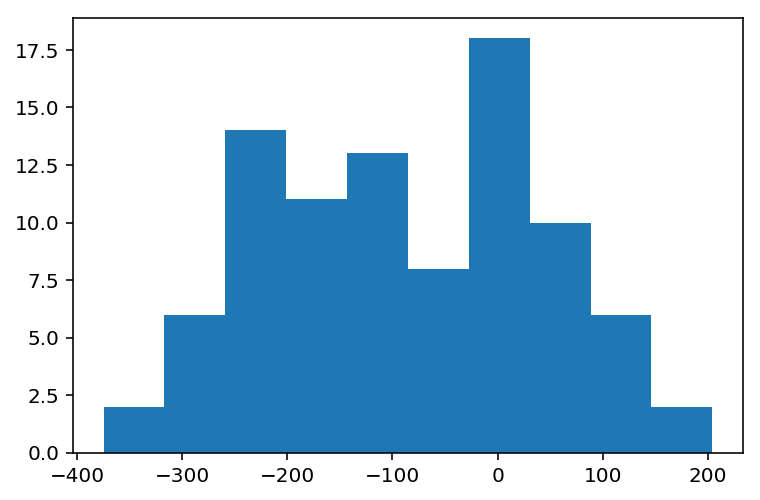

In [24]:
plt.hist(PNe_df["V (km/s)"],bins=10)
mu, std = norm.fit(PNe_df["V (km/s)"])
print(mu, std)

## The Great Filter

138


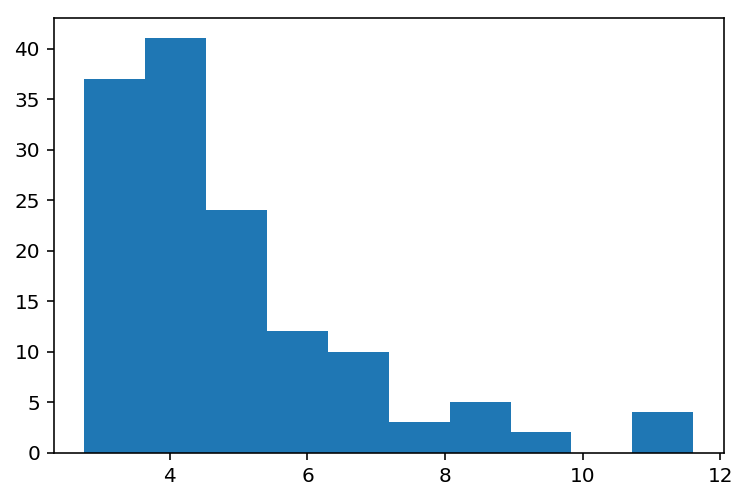

In [91]:
PNe_df.loc[PNe_df["m 5007"]>30, "Filter"] = "N"
PNe_df.loc[PNe_df["A/rN"]<2.75, "Filter"] = "N"
# PNe_df.loc[PNe_df["[OIII]/Hb"]>20, "[OIII]/Hb"] = "-"
#PNe_df.loc[PNe_df["PNe number"]==19, "Filter"] = "Y"


print(len(PNe_df["Filter"].loc[PNe_df["Filter"]=="Y"]))
plt.hist(PNe_df["A/rN"].loc[PNe_df["Filter"]=="Y"]);
plt.show()

# Error analysis

In [92]:
def Moffat_err(Moff_A, FWHM, beta, x_0, y_0):
        gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
        rr_gg = ((np.array(x_fit) - x_0)**2 + (np.array(y_fit) - y_0)**2) / gamma**2
        F_OIII_xy_dist = Moff_A * (1 + rr_gg)**(-beta)
    
        return np.sum(F_OIII_xy_dist*1e-20)
    
def error_sim(n_sim, n_PNe):
    mean_flux = np.ones(n_PNe)
    flux_err  = np.ones(n_PNe)
    for n in np.arange(0,n_PNe):
        Moff_A_dist = np.random.normal(emission_amp_list[n][0], moff_A_err[n][0],n_sim)
        FWHM_dist = np.random.normal(galaxy_data["FWHM"], galaxy_data["FWHM_err"], n_sim)
        beta_dist = np.random.normal(galaxy_data["beta"], galaxy_data["beta_err"], n_sim)
        x_0_dist = np.random.normal(list_of_x[n], x_0_err[n][0], n_sim)
        y_0_dist = np.random.normal(list_of_y[n], y_0_err[n][0], n_sim)
        
        flux_array = [Moffat_err(Moff_A_dist[i], FWHM_dist[i], beta_dist[i], x_0_dist[i], y_0_dist[i]) for i in range(0,n_sim)]
        
        mean_flux[n], flux_err[n] = norm.fit(flux_array)
        
        #mu_m, std_m = norm.fit(-2.5*np.log10(flux_array)-13.72)

    return mean_flux, flux_err

mean_flux, flux_err = error_sim(10000, len(x_PNe))

PNe_df["Flux error"] = flux_err

0.008281856731713333


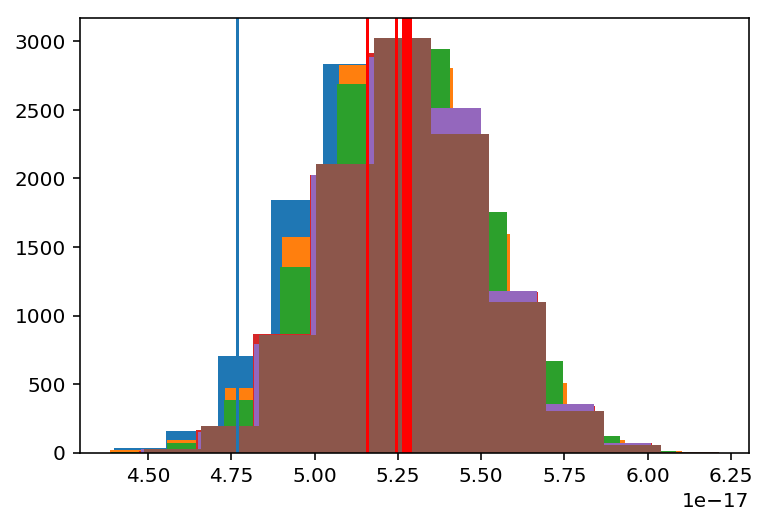

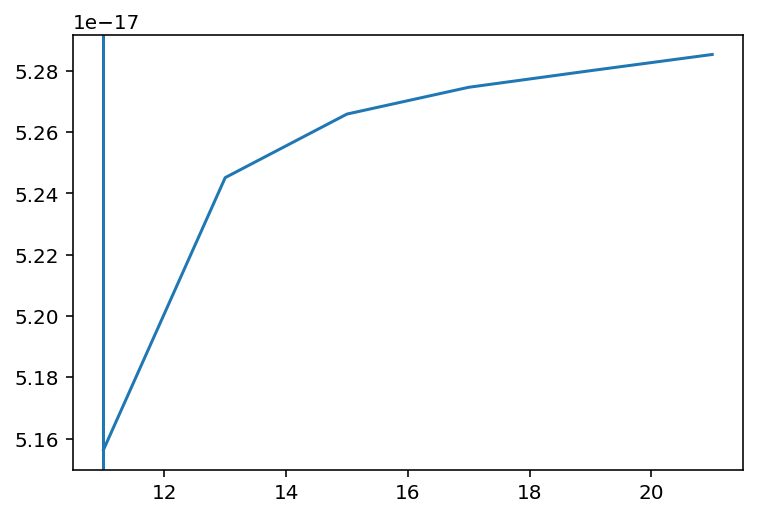

In [11]:
# n_pix_dist = 31
n_range = np.arange(11,22,2)
store_here = np.ones(len(n_range))
for i, n_pix_dist in enumerate(n_range):
    coordinates = [(n,m) for n in range(n_pix_dist) for m in range(n_pix_dist)]
    x_fit = np.array([item[0] for item in coordinates])
    y_fit = np.array([item[1] for item in coordinates])
    
    n_sim = 10000
    Moff_A_dist = np.random.normal(emission_amp_list[40][0], moff_A_err[40][0],n_sim)
    FWHM_dist = np.random.normal(4.06, 0.018, n_sim)
    beta_dist = np.random.normal(3.41, 0.167, n_sim)
    x_0_dist = np.random.normal(list_of_x[40], x_0_err[40][0], n_sim)
    y_0_dist = np.random.normal(list_of_y[40], y_0_err[40][0], n_sim)
    
    def Moffat_err(Moff_A, FWHM, beta, x_0, y_0):
        gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
        rr_gg = ((np.array(x_fit) - x_0)**2 + (np.array(y_fit) - y_0)**2) / gamma**2
        F_OIII_xy_dist = Moff_A * (1 + rr_gg)**(-beta)
    
    
        return np.sum(F_OIII_xy_dist*1e-20)
    
    flux_array = [Moffat_err(Moff_A_dist[i], FWHM_dist[i], beta_dist[i], x_0_dist[i], y_0_dist[i]) for i in range(0,n_sim)]
    plt.hist(flux_array)
    plt.axvline(PNe_df["[OIII] Flux"].iloc[40])
#     plt.xlim(3.6e-17, 4.2e-17)
    #print(PNe_df["[OIII] Flux"].iloc[40])
    #print(PNe_df["m 5007"].iloc[40])
    mu_f, std_f = norm.fit(flux_array)
    #print(mu, (std/mu)*100,"%")
    plt.axvline(mu_f, c="r")
    
    mu, std = norm.fit(-2.5*np.log10(flux_array)-13.72)
    #print(mu, std)
    store_here[i] = mu_f

print(np.abs((-2.5*np.log10(store_here.max()) - 13.74)  -  (-2.5*np.log10(store_here[1]) - 13.74)))

plt.figure()
plt.plot(n_range, store_here)
plt.axvline(n_pixels)
# Correction for n_pixel and flux variation from fit

In [93]:
PNe_df["F[OIII] err percent"] = (PNe_df["Flux error"] / PNe_df["[OIII] Flux"])*100

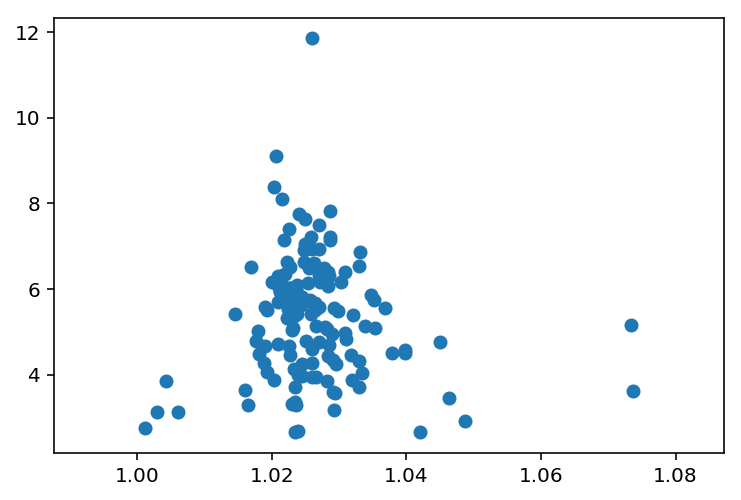

In [97]:
plt.scatter(PNe_df["Chi^2"], PNe_df["F[OIII] err percent"])

In [13]:
## Distance estimate with error?

p_n = 48
flux = PNe_df["[OIII] Flux"].iloc[p_n]
print(flux)
flux_err = PNe_df["Flux error"].iloc[p_n]

m = -2.5 * np.log10(flux) - 13.74
m_plus = -2.5 * np.log10(flux  + flux_err) - 13.74
m_minus = -2.5 * np.log10(flux - flux_err) - 13.74

Dist_est = 10.**(((m + 4.47) -25.) / 5.)
dist_diff_p = 10.**(((m_plus + 4.47) -25.) / 5.)
print("Lower: ", dist_diff_p)
dist_diff_m = 10.**(((m_minus + 4.47) -25.) / 5.)
print("Upper: ", dist_diff_m)
print("Distance Estimate from PNLF: ", Dist_est, "Mpc, +/-", np.median((Dist_est- dist_diff_p, dist_diff_m -Dist_est)),"Mpc")

7.0710152440638e-17
Lower:  16.292742407621716
Upper:  17.019116989301597
Distance Estimate from PNLF:  16.64405388851892 Mpc, +/- 0.3631872908399405 Mpc


In [88]:
PNe_df.nsmallest(10,"m 5007").loc[PNe_df["Filter"]=="Y"]

,PNe number,Ra (J2000),Dec (J2000),V (km/s),m 5007,M 5007,M 5007 error,A/rN,rad D,Chi^2,Filter,[OIII] Flux,[OIII]/Hb
29,29,NaN,NaN,-65.472753,26.402608,-4.956600,NaN,11.603384,NaN,1.023904,Y,8.769139e-17,68.618015
73,73,NaN,NaN,-145.833170,26.775731,-4.583477,NaN,5.901110,NaN,1.029568,Y,6.218816e-17,15.690463
70,70,NaN,NaN,-126.630310,26.824729,-4.534479,NaN,4.873180,NaN,1.045049,Y,5.944407e-17,10.718845
14,14,NaN,NaN,-13.125725,26.840176,-4.519032,NaN,11.407119,NaN,1.042080,Y,5.860433e-17,19.518176
74,74,NaN,NaN,39.463657,26.872883,-4.486325,NaN,5.680787,NaN,1.024486,Y,5.686523e-17,16.588531
30,30,NaN,NaN,6.900047,26.926316,-4.432892,NaN,6.617030,NaN,1.032973,Y,5.413444e-17,6.306647
140,140,NaN,NaN,-336.931113,26.942772,-4.416436,NaN,11.577108,NaN,1.001099,Y,5.332011e-17,10.496048
118,118,NaN,NaN,-108.866745,26.951508,-4.407700,NaN,7.674544,NaN,1.023040,Y,5.289283e-17,3.866088
54,54,NaN,NaN,-157.142732,26.959064,-4.400144,NaN,8.368731,NaN,1.029266,Y,5.252600e-17,13.862082
20,20,NaN,NaN,-4.753310,26.976899,-4.382309,NaN,8.078955,NaN,1.023542,Y,5.167021e-17,5.525152


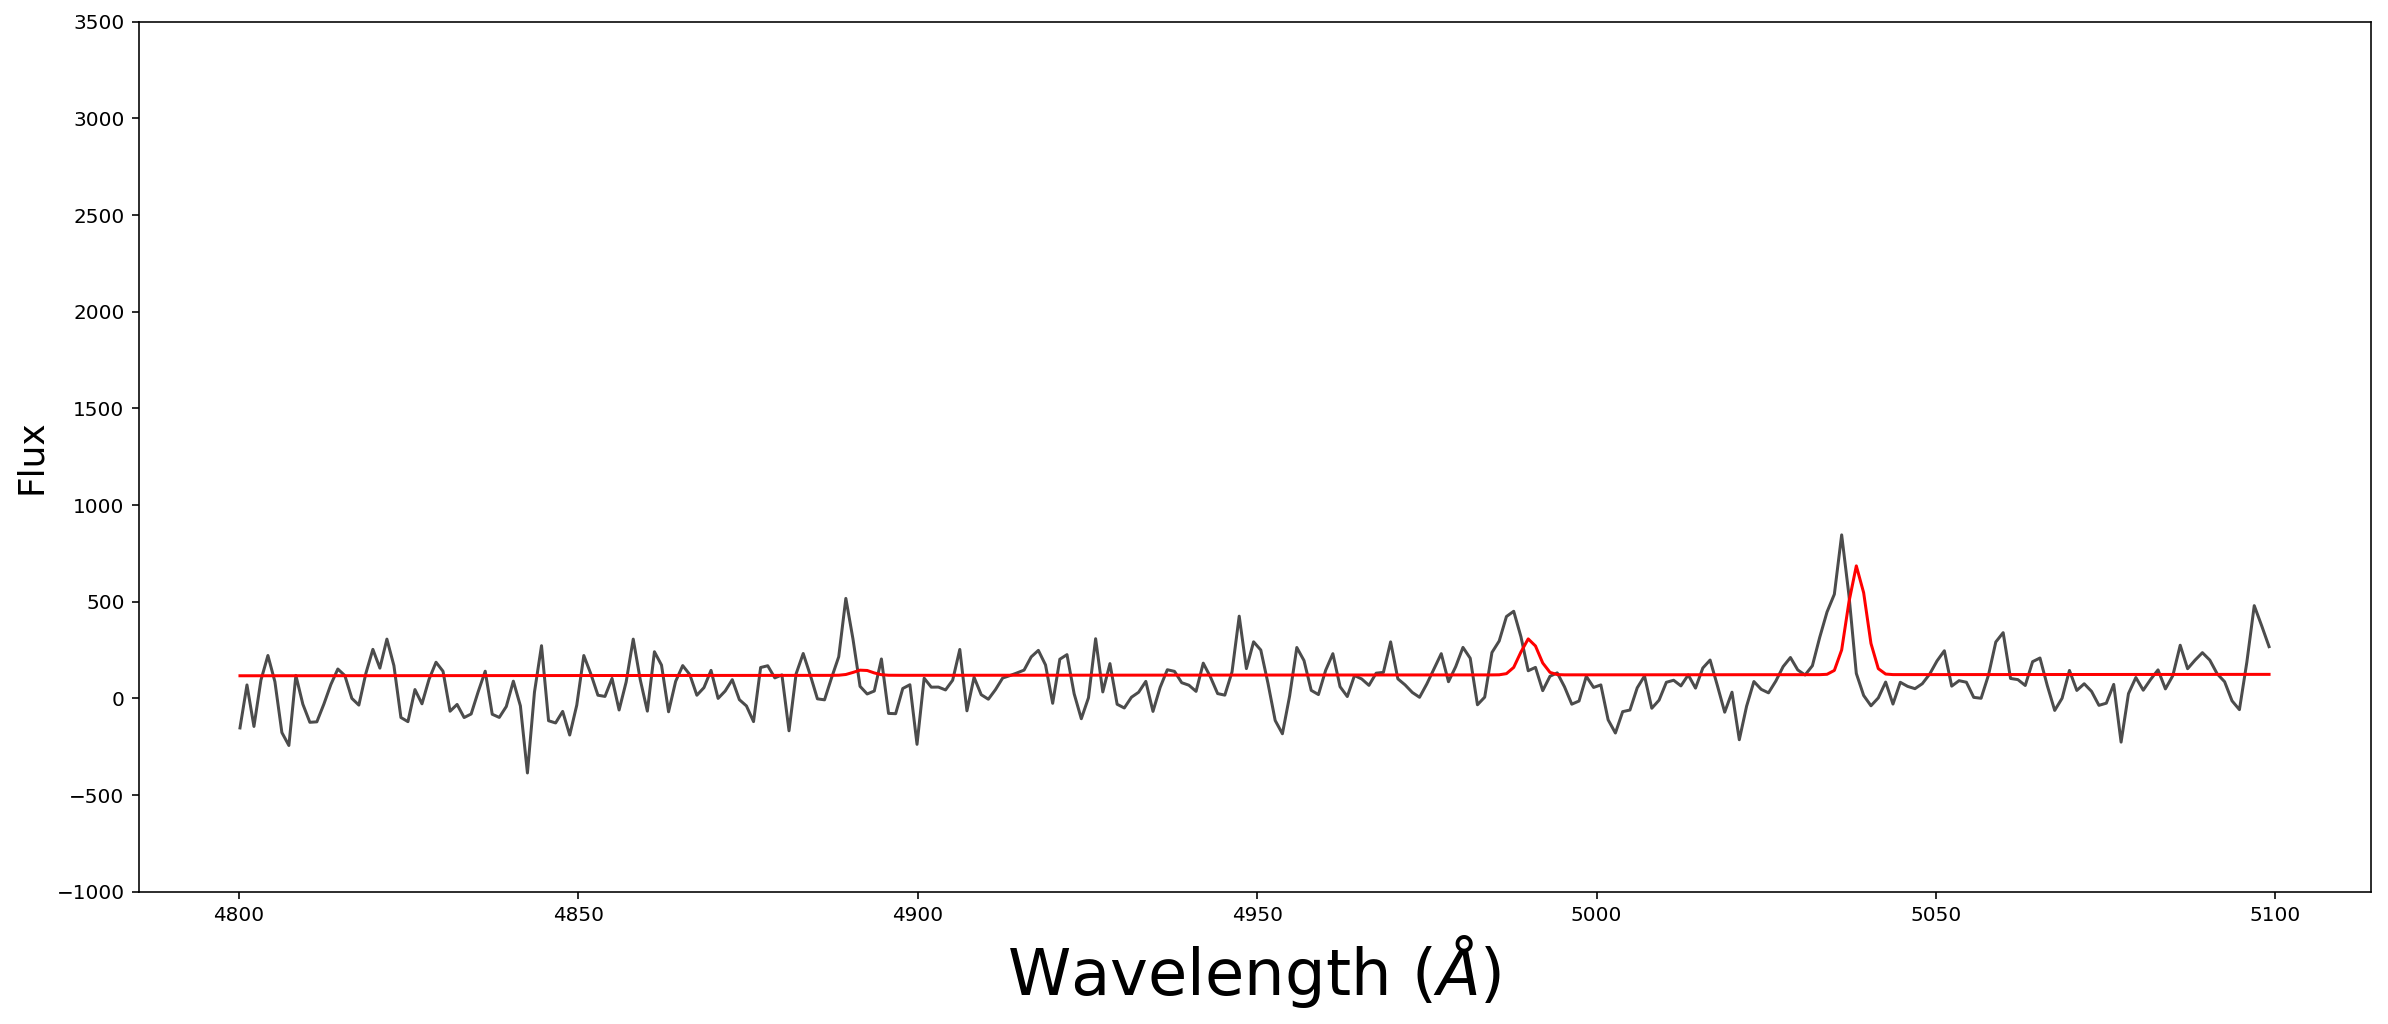

In [99]:
p = 138
plt.figure(figsize=(20,8))
plt.plot(wavelength, np.sum(PNe_spectra[p],0), alpha=0.7, c="k")

plt.plot(wavelength, np.sum(model_spectra_list[p],0), c="r")
plt.xlabel("Wavelength ($\AA$)", fontsize=32)
plt.ylabel("Flux", fontsize=18);
plt.ylim(-1000,3500);
#plt.xlim(4900,5100)
# plt.axvline(5033)

In [107]:
PNe_n.shape

(81, 283)

In [106]:
PNe_n[np.where(PNe_n[:,0]!=0)].shape

(78, 283)

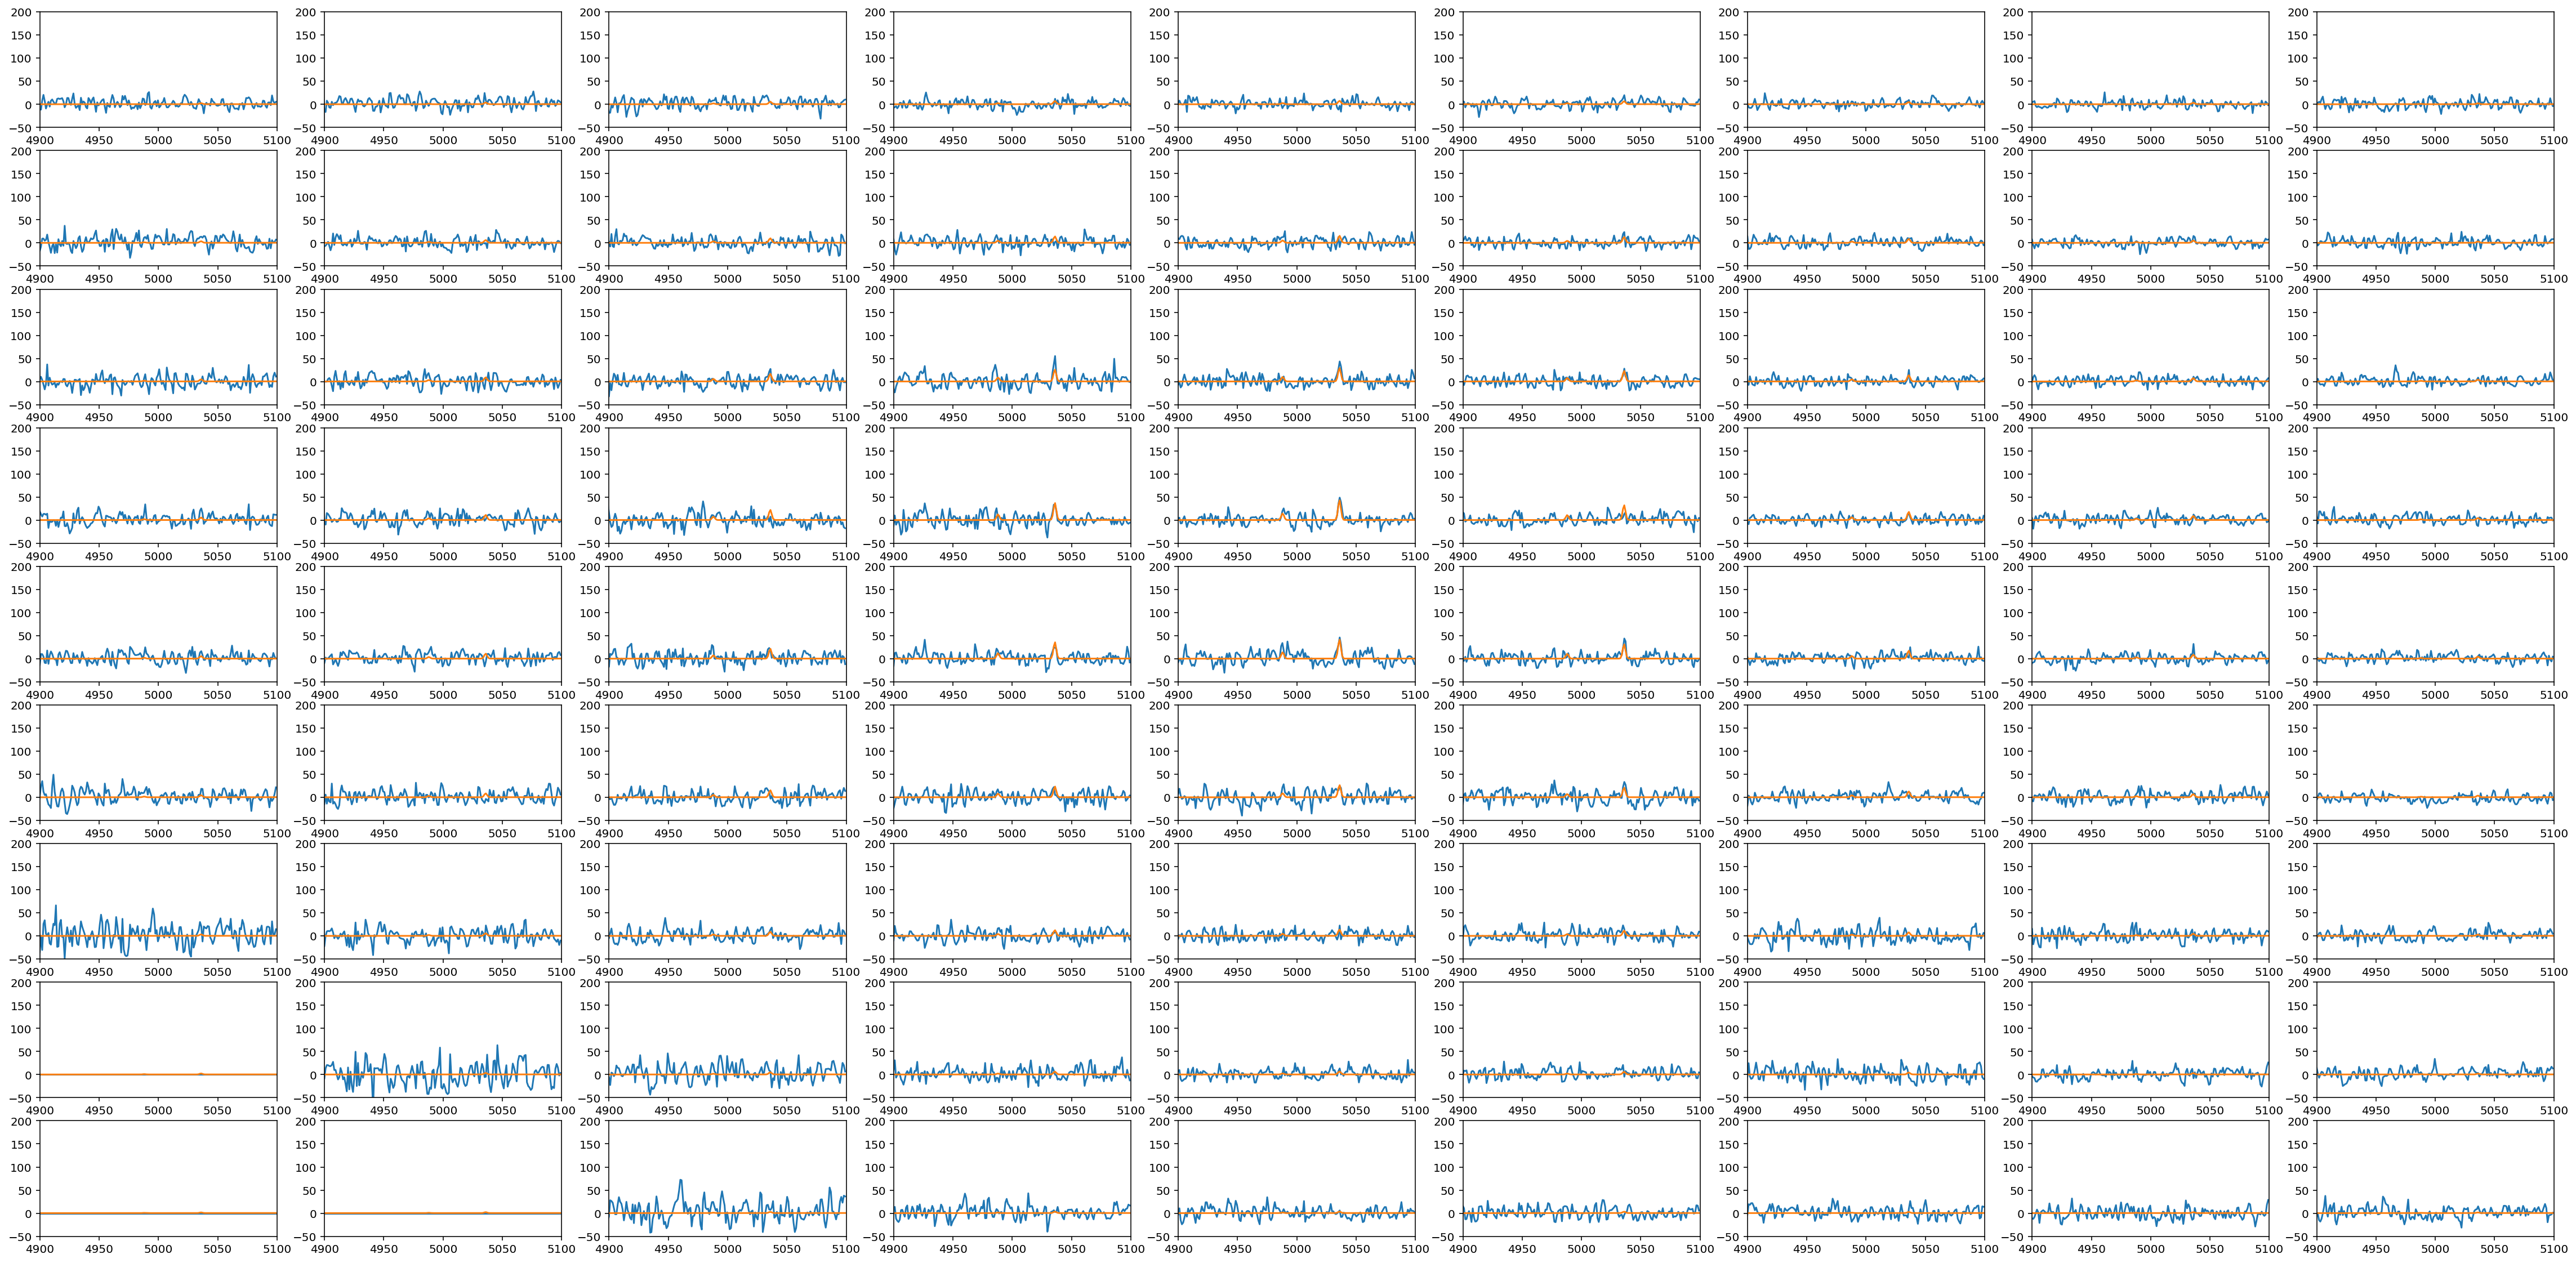

In [9]:
p = 138
PNe_n = PNe_spectra[p]
flux_1D = F_xy_list[p][0]
A_n = ((flux_1D) / (np.sqrt(2*np.pi) * 1.19))

def gaussian(x, amplitude, mean, stddev, bkg, grad):
    return (bkg + grad*x + np.abs(amplitude) * np.exp(- 0.5 * (x - mean)** 2 / (stddev**2.)) +
            (np.abs(amplitude)/3.) * np.exp(- 0.5 * (x - (mean - 47.9399))** 2 / (stddev**2.)))

list_of_gauss = [gaussian(wavelength, A, mean_wave_list[p][0], 1.19, Gauss_bkg[p], Gauss_grad[p]) for A in A_n]

plt.figure(figsize=(40,20))
for i, spec in enumerate(PNe_n):
    plt.subplot(n_pixels,n_pixels,i+1)
    plt.plot(wavelength, spec)
    plt.plot(wavelength, list_of_gauss[i])
    plt.xlim(4900,5100)
    plt.ylim(-50, 200)
    

In [ ]:
plt.figure(figsize=(12,8))
plt.yscale("log")
plt.scatter(PNe_df["M 5007"], PNe_df["[OIII]/Ha+[NII]"])
#plt.axhline(2)
plt.ylim(0.03,20)
plt.xlim(-5,-2)
x = np.arange(-5, -2,0.001)
plt.plot(x, 10**((-0.37 * x) - 1.16))
plt.ylabel("$F[OIII] \ / \ (F[Ha]+F[NII])$", fontsize="20")
plt.xlabel("$M_{5007}$", fontsize="20")
# plt.savefig("Plots/FCC167/[OIII]Ha+NII.png")

# Load in data and plot FOV

In [33]:
# Pull out the 1D flux data from 1D fits to do radial comparison

gauss_1D_A = np.load("exported_data/"+gal_name+"/gauss_A_cen.npy")
A_rN_plot = np.load("exported_data/"+gal_name+"/A_rN_cen.npy")

gauss_A_shape = gauss_1D_A.reshape(y_data, x_data)
rN = np.load("exported_data/"+gal_name+"/rN.npy")
rN_shape = rN.reshape(y_data,x_data)
#rN_shape[np.isnan(rN_shape)] = 0

Flux_1D = gauss_1D_A * np.sqrt(2*np.pi) * 1.19
Flux_1D_cube = Flux_1D.reshape(y_data, x_data)
A_rN_plot_shape = A_rN_plot.reshape(y_data, x_data)

#PNe_1D_flux_data = np.array([PNextractor(x, y, n_pixels, Flux_1D_cube, dim=1.0) for x,y in zip(x_PNe,y_PNe)])
#PNe_1D_A_rN_data = np.array([PNextractor(x, y, n_pixels, A_rN_plot_shape, dim=1.0) for x,y in zip(x_PNe,y_PNe)])

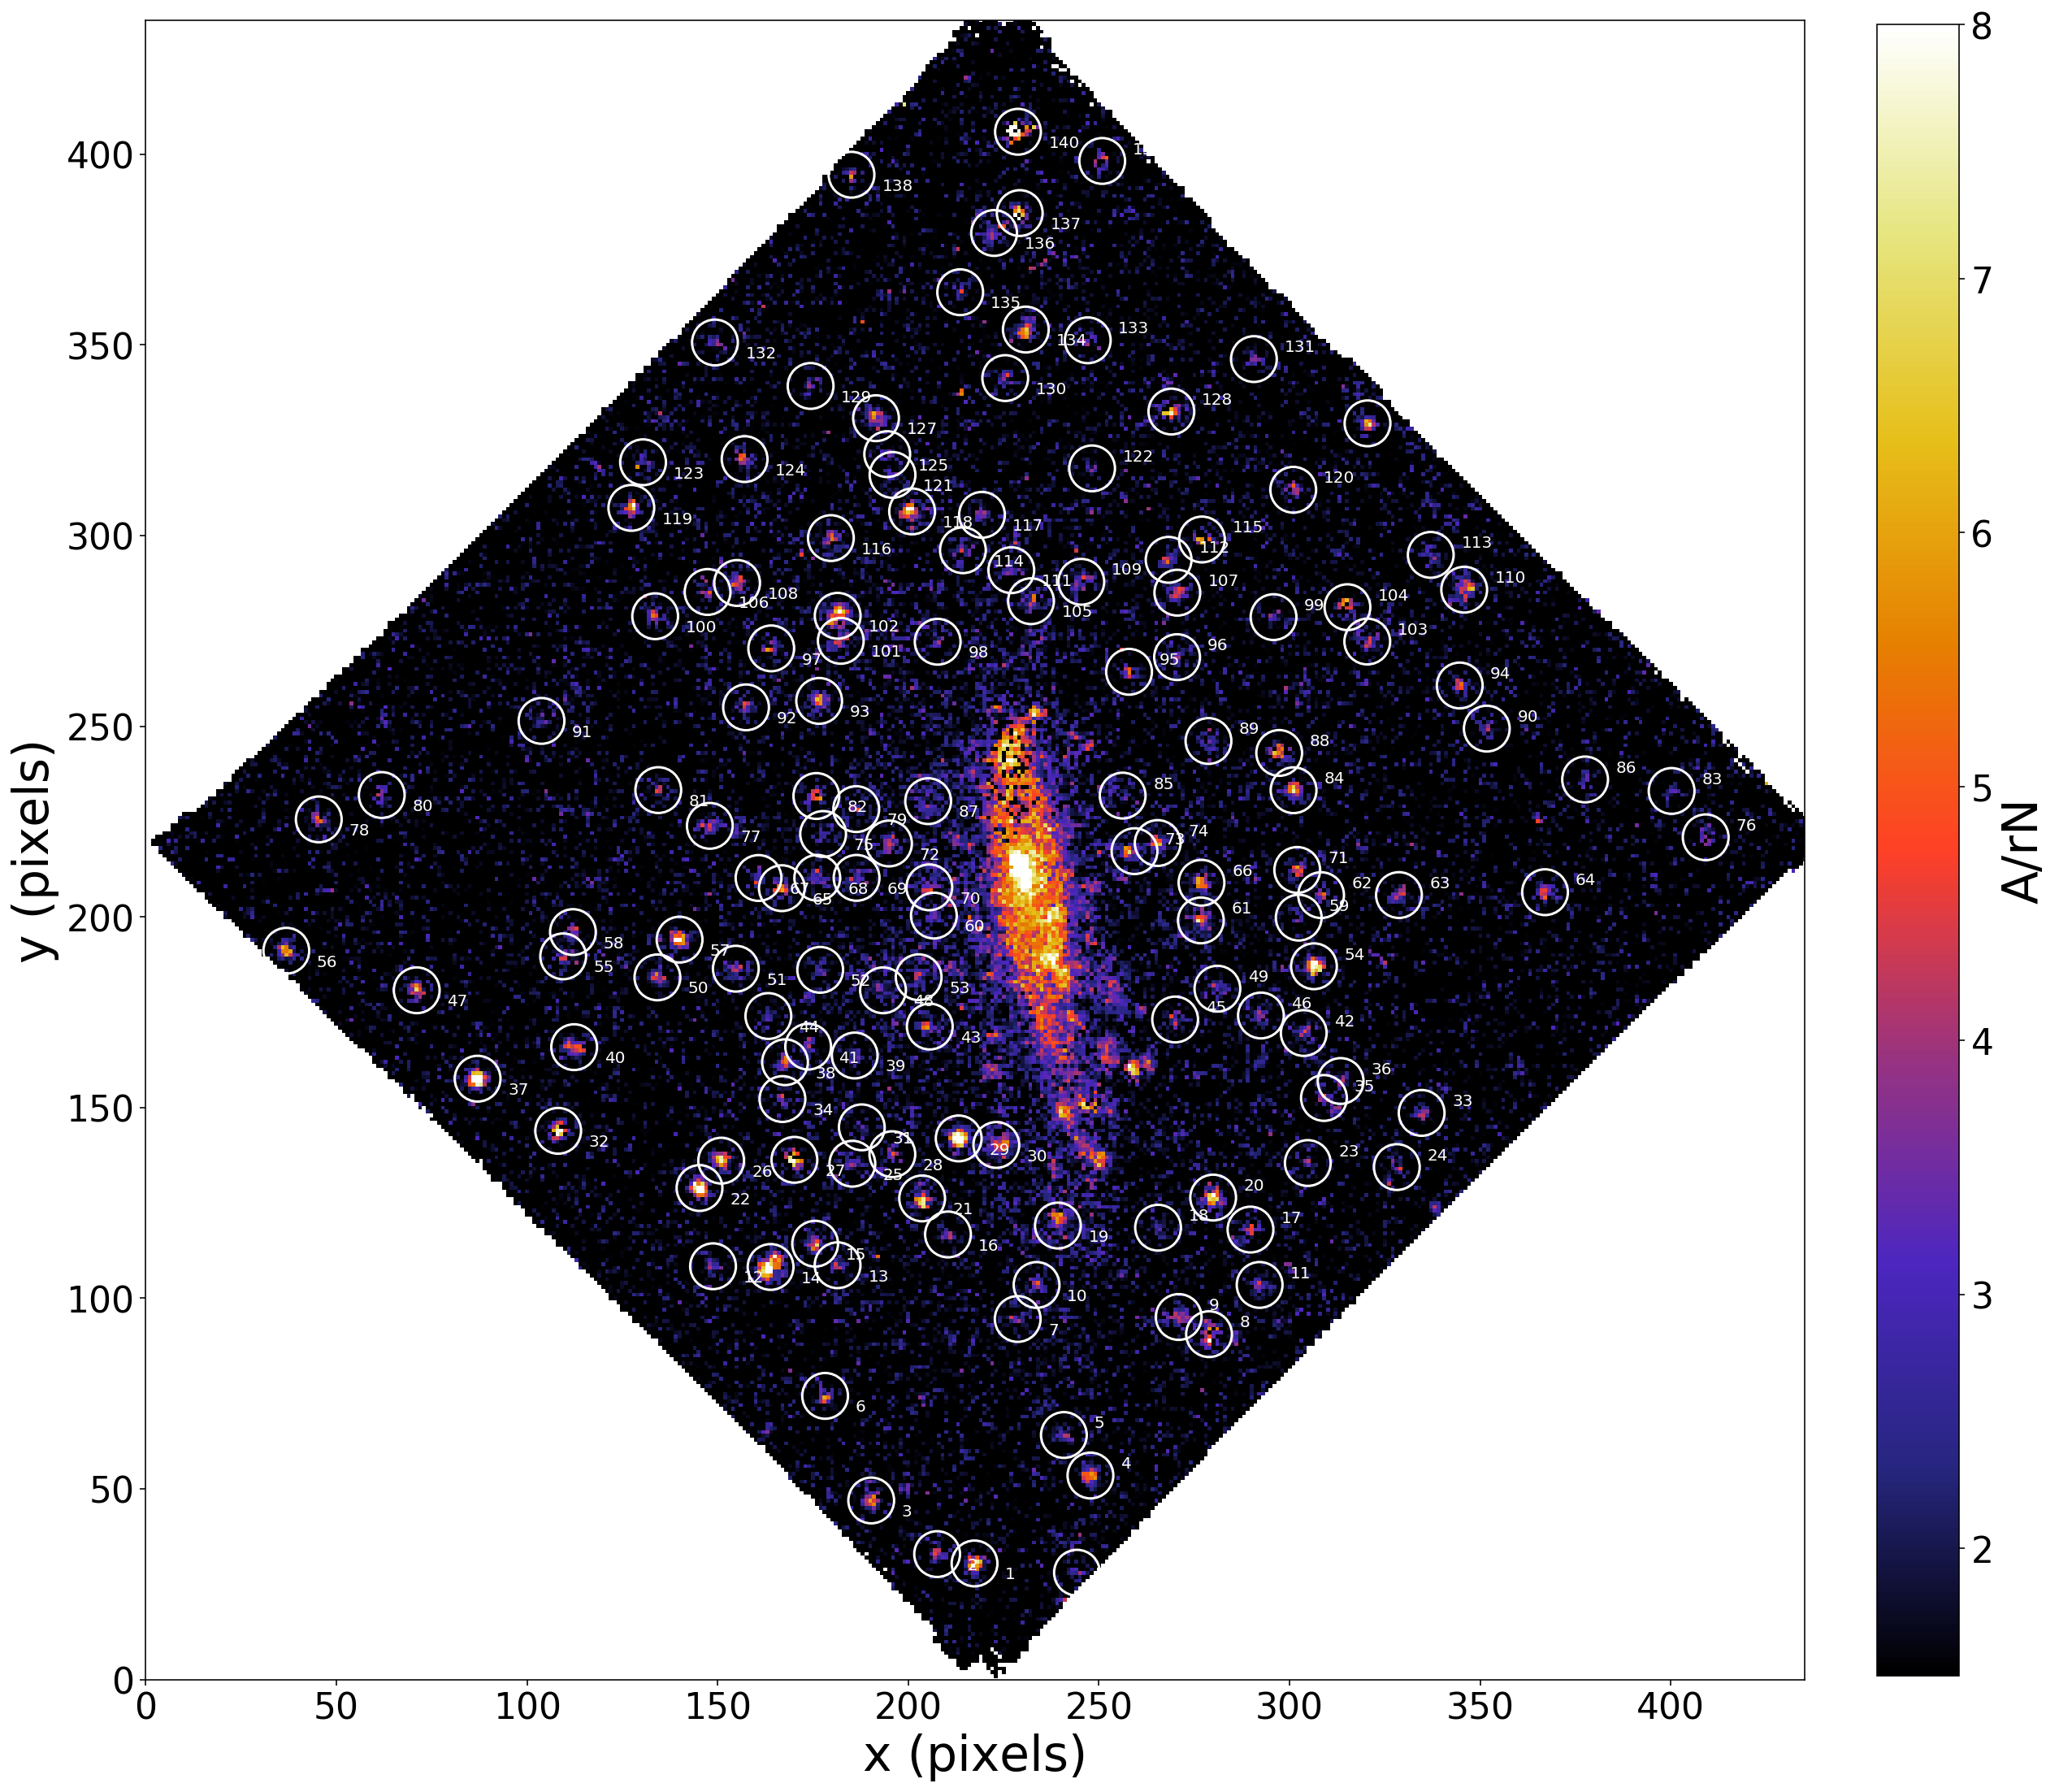

In [67]:

plt.figure(figsize=(20,20))
plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap",  vmin=1.5, vmax=8)
ax = plt.gca()
cb=plt.colorbar(fraction=0.0455, pad=0.04)
cb.set_label("A/rN",fontsize=30)
cb.ax.tick_params(labelsize=22)

plt.xlabel("x (pixels)", fontsize=30)
plt.ylabel("y (pixels)", fontsize=30)

plt.tick_params(labelsize = 22)

plt.ylim(0,435)
plt.xlim(0,435)

#circ_r = plt.Circle((195,100), 45, color="white", fill=False)
#ax.add_artist(circ_r)
# elip_gal = Ellipse((205, 90), 150, 100, angle=1.8*(180/np.pi), fill=False, color="white")
# ax.add_artist(elip_gal)
# 
for i, item in enumerate(x_y_list):
    ax = plt.gca()
    circ = plt.Circle((item[0],item[1]),6, color="white",lw=1.5, fill=False)
    ax.add_artist(circ)
    if item[0]<240.:
        ax.annotate(i, (item[0]+8, item[1]-4), color="white", size=10)
    else:
        ax.annotate(i, (item[0]+8, item[1]+2), color="white", size=10)

# plt.savefig("Plots/"+gal_name+"/A_rN_circled.pdf")

# Scatter points for measured PNe velocity

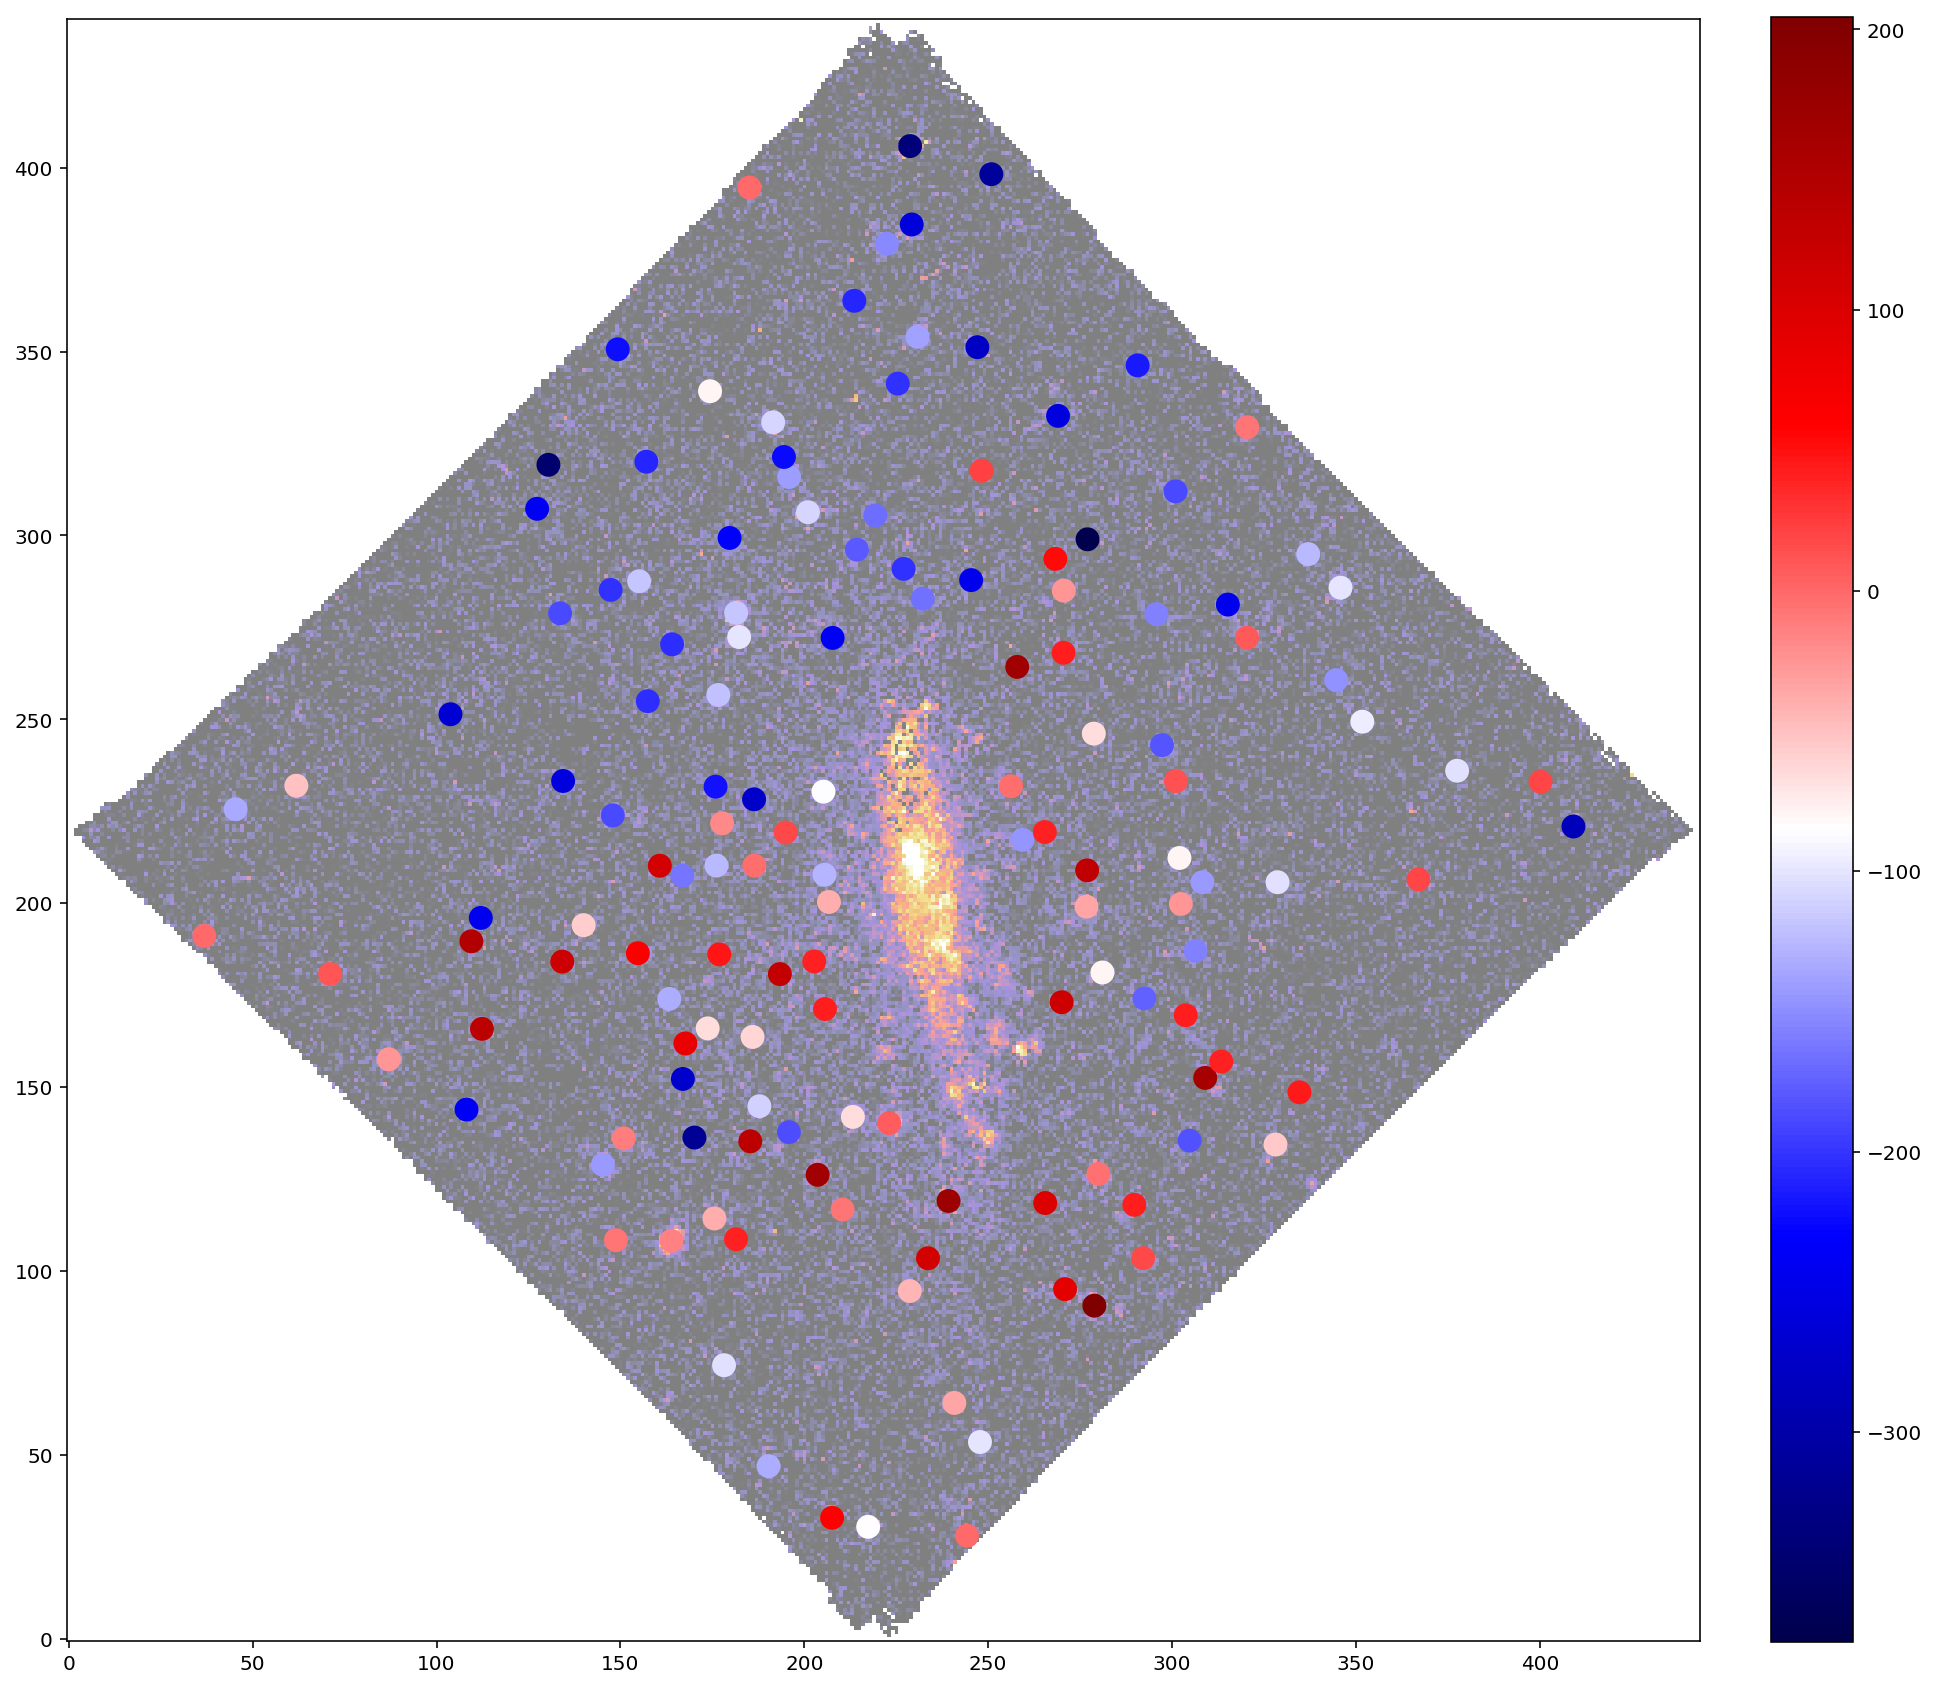

In [72]:
# Scatter plot the x y locations of PNe, colour coding them with their velocity

positions = (x_PNe, y_PNe)
apertures = CircularAperture(positions, r=4)
plt.figure(figsize=(16,16))
plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap", vmin=1, vmax=8., alpha=0.5)
plt.scatter(x_PNe, y_PNe, c=PNe_df["V (km/s)"], cmap="seismic", s=120)
# plt.scatter(x_PNe, y_PNe, c=PNe_df["m 5007"], cmap="inferno_r", s=120)

cb = plt.colorbar(fraction=0.0455, pad=0.04)
# cb.set_label("$V_{[OIII]} \ (km \ s^{-1}$)", fontsize=20)
#plt.savefig("Plots/"+gal_name+"/PNe_velocity_dist_map.pdf")

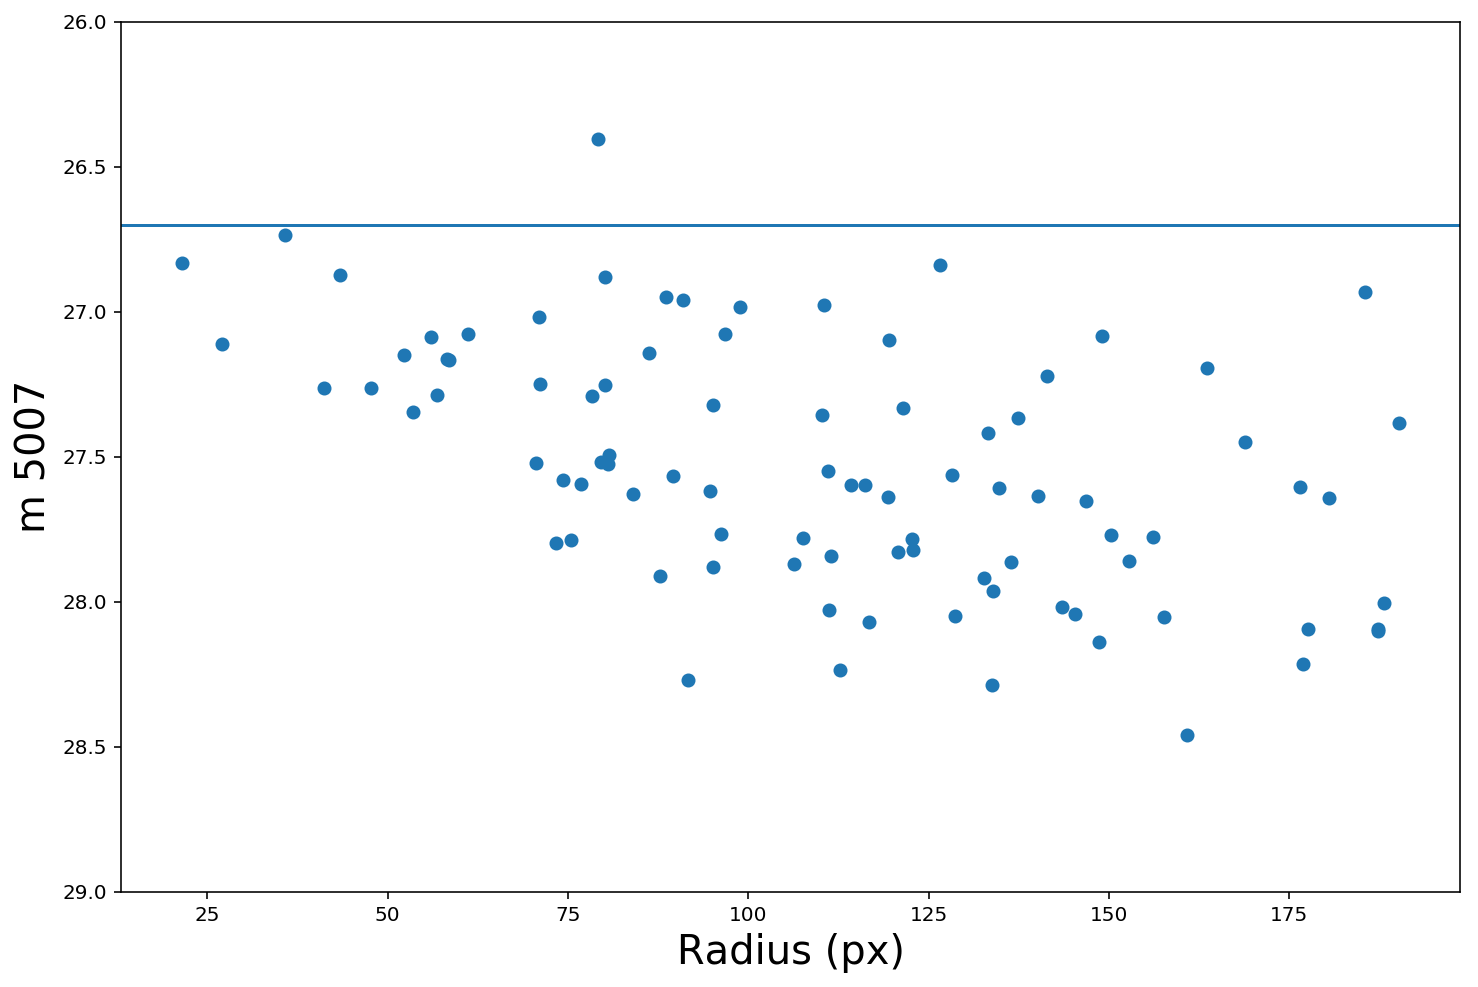

In [31]:
plt.figure(figsize=(12,8))
rad = [np.sqrt((x-x_data/2.)**2 + (y - y_data/2.)**2) for x,y in zip(x_PNe, y_PNe)]
plt.scatter(rad, PNe_df["m 5007"])

plt.axhline(26.7)
plt.ylabel("m 5007", fontsize=20)
plt.xlabel("Radius (px)", fontsize=20)
plt.ylim(29,26)
plt.savefig("Plots/"+gal_name+"/rad_v_mag.pdf")

(-5, -2)

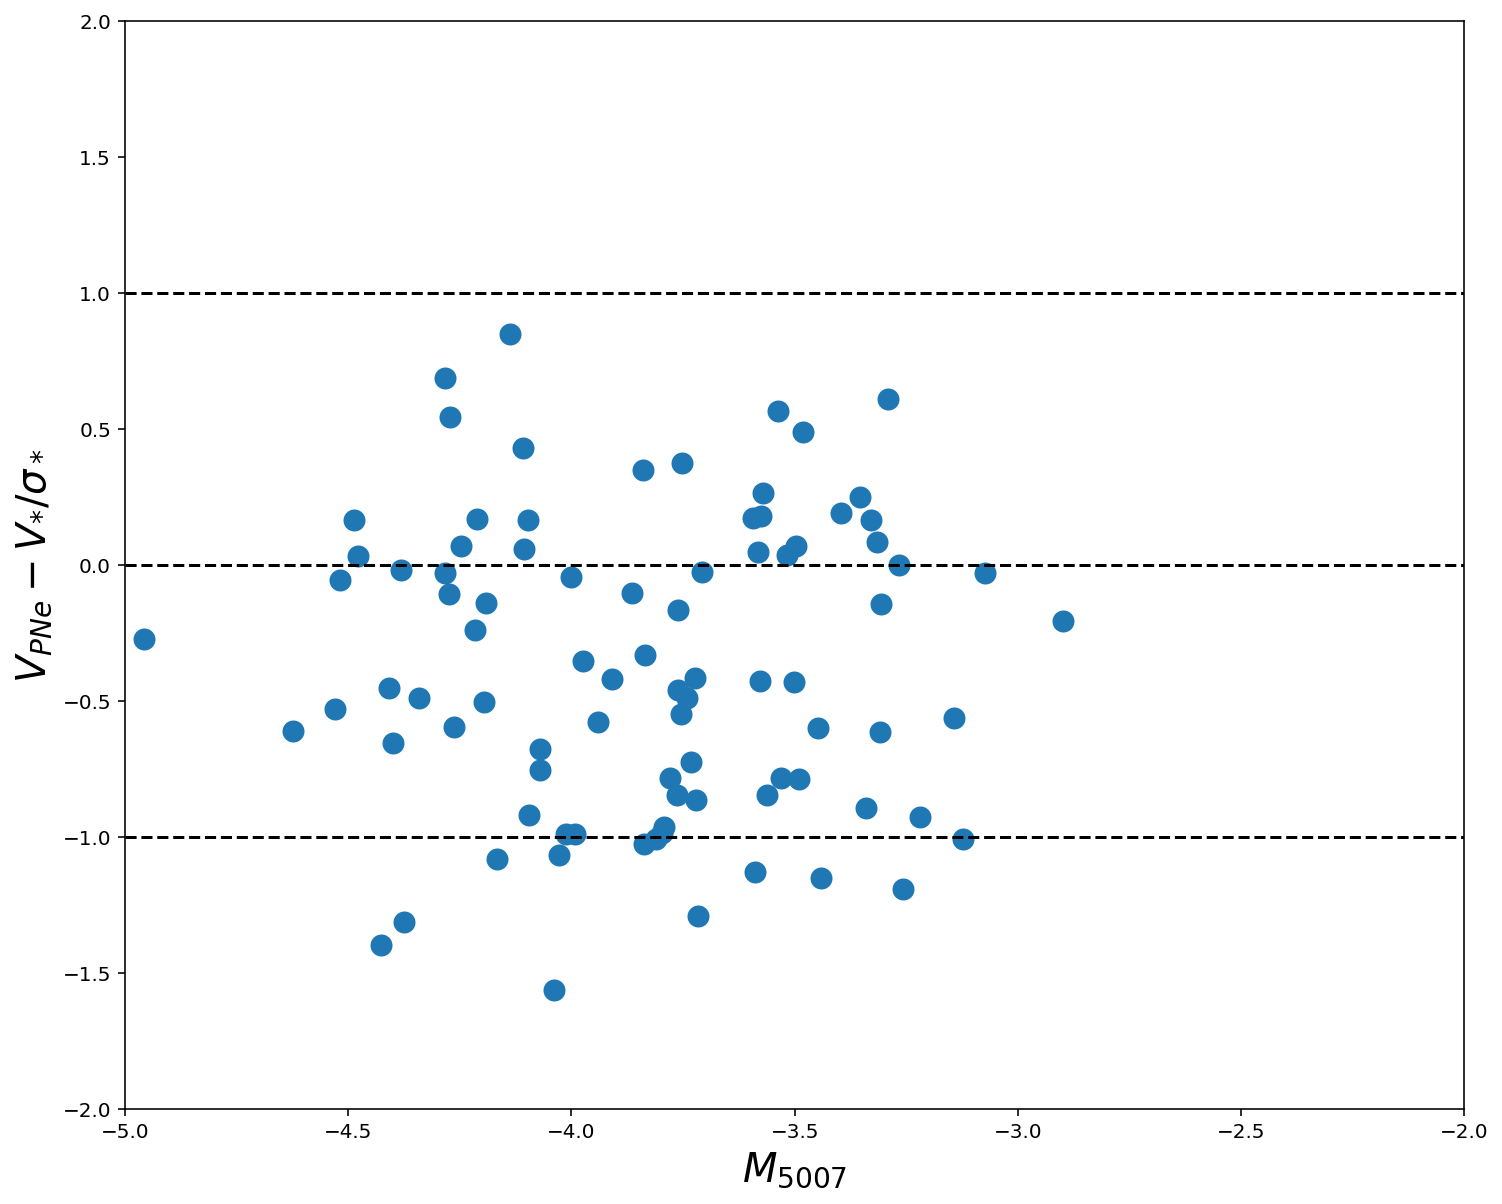

In [32]:
stellar_vel = 0. # km/s
stellar_dis = 240. # km/s
PNe_vel_ratio = (PNe_df["V (km/s)"].loc[PNe_df["A/rN"]>3.] - stellar_vel)/ stellar_dis

plt.figure(44, figsize=(12,10))
plt.clf()
plt.scatter(PNe_df["M 5007"].loc[PNe_df["A/rN"]>3.], PNe_vel_ratio, s=100)
plt.xlabel("$M_{5007}$", fontsize=20)
plt.ylabel("$V_{PNe} - V_{*} / \sigma_*$", fontsize=20)
plt.axhline(y=1, c="k", ls="dashed")
plt.axhline(y=0, c="k", ls="dashed")
plt.axhline(y=-1, c="k", ls="dashed")
plt.ylim(-2,2)
plt.xlim(-5,-2)

# SEP - Source Detection

141


<Figure size 1440x1440 with 0 Axes>

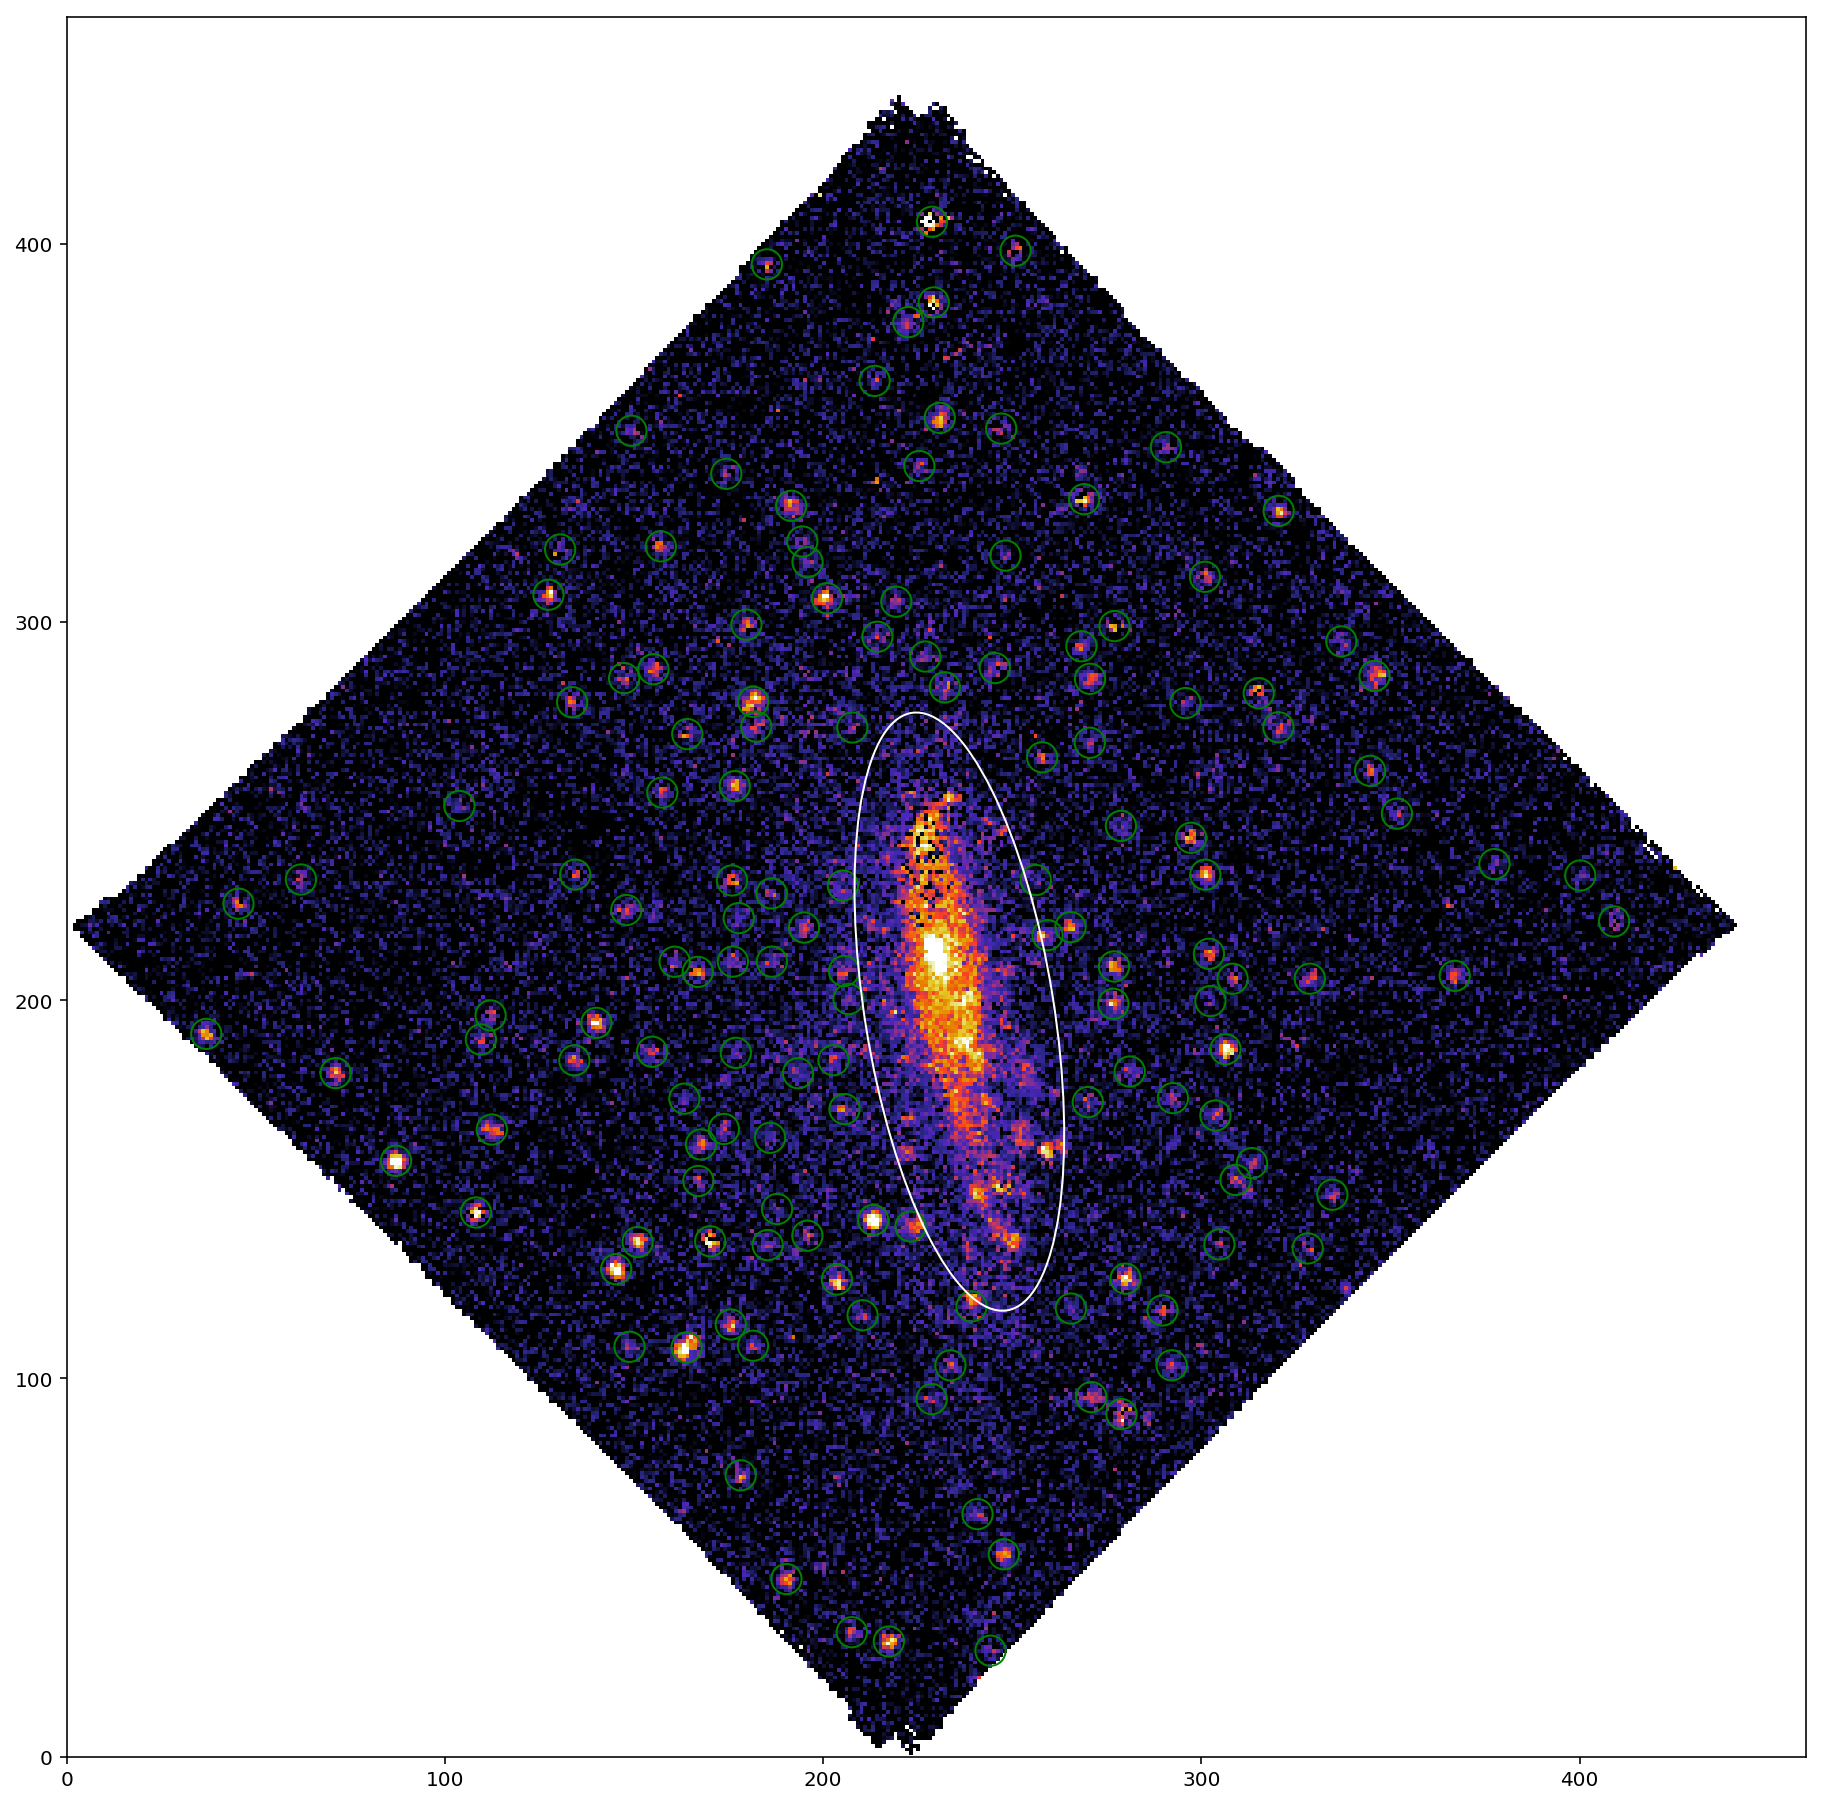

In [52]:
A_rN_plot_shape[A_rN_plot_shape == A_rN_plot_shape[0,0]] = 0.0
plt.figure(figsize=(20,20))

Y, X = np.mgrid[:y_data, :x_data]
if gal_name == "FCC219":
    xe = 205
    ye = 90
    length= 100
    width = 150
    alpha = 1.8
elif gal_name == "FCC167":
    xe = 236
    ye = 197
    length= 160
    width = 50
    alpha = 3.3


elip_mask_gal = (((X-xe) * np.cos(alpha) + (Y-ye) * np.sin(alpha)) / (width/2)) ** 2 + (((X-xe) * np.sin(alpha) - (Y-ye) * np.cos(alpha)) / (length/2)) ** 2 <= 1
# xc = 195
# yc = 100
# r = 45
# circ_mask_gal = (X - xc)**2 + (Y-yc)**2 <=r**2
#PNe_mask = (X - 379)**2 + (Y-151)**2 <=10**2
        

objects = sep.extract(A_rN_plot_shape, 2., clean=True, filter_type="conv", mask=elip_mask_gal)
x_sep = objects["x"]
y_sep = objects["y"]

positions = (x_sep, y_sep)
apertures = CircularAperture(positions, r=4)
plt.figure(figsize=(16,16))
plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap", vmin=1, vmax=8.)
apertures.plot(color="green")

ax = plt.gca()

#circ_gal = Circle((xc,yc), r, fill=False, color="white")
#ax.add_artist(circ_gal)

elip_gal = Ellipse((xe, ye), width, length, angle=alpha*(180/np.pi), fill=False, color="white")
#PNe_14 = Circle((379,151), fill=False, color="white")
ax.add_artist(elip_gal)


sep_x_y_list = [[x,y] for x,y in zip(x_sep, y_sep)]
plt.xlim(0,460)
plt.ylim(0,460)
print(len(x_sep))

np.save("exported_data/"+gal_name+"/PNe_x_y_list", sep_x_y_list)

# PSF

In [12]:
PNe_df.nlargest(10, "A/rN")

,PNe number,Ra (J2000),Dec (J2000),V (km/s),m 5007,M 5007,M 5007 error,A/rN,rad D,Chi^2,Include,FWHM,beta,[OIII] Flux
19,19,NaN,NaN,-65.826495,26.532290,-4.826918,NaN,12.051017,NaN,1.040913,NaN,4.0,2.5,7.781867e-17
10,10,NaN,NaN,-14.288554,27.015796,-4.343412,NaN,11.598425,NaN,1.093927,NaN,4.0,2.5,4.985188e-17
23,23,NaN,NaN,-25.552776,27.255052,-4.104156,NaN,11.210024,NaN,1.040086,NaN,4.0,2.5,3.999254e-17


In [87]:
### Single Run PSF Fitter
#sel_PNe = PNe_df.nsmallest(4, "m 5007").index.values
#sel_PNe = PNe_df.nlargest(12, "A/rN").index.values
sel_PNe = PNe_df.loc[PNe_df["PNe number"] != 1].nlargest(10, "A/rN").index.values

#sel_PNe = [19,23, 35]#69, 66, 65 ]#, 6,  1, 33, 61, 62]
print(sel_PNe)

selected_PNe = PNe_spectra[sel_PNe]
selected_PNe_err = obj_error_cube[sel_PNe]
PSF_params = Parameters()

def model_params(p, n, amp, mean):
    PSF_params.add("moffat_amp_{:03d}".format(n), value=amp)
    PSF_params.add("x_{:03d}".format(n), value=n_pixels/2., min=0.1, max=n_pixels)
    PSF_params.add("y_{:03d}".format(n), value=n_pixels/2., min=0.1, max=n_pixels)
    PSF_params.add("wave_{:03d}".format(n), value=mean, min=mean-50., max=mean+50.)
    PSF_params.add("gauss_bkg_{:03d}".format(n),  value=0.01, vary=True )
    PSF_params.add("gauss_grad_{:03d}".format(n), value=0.001, vary=True)


for i in np.arange(0,len(sel_PNe)):
        model_params(p=PSF_params, n=i, amp=200.0, mean=5007*(1+z))    
    
PSF_params.add('FWHM', value=4.0, min=0.01, vary=True)
PSF_params.add("beta", value=2.5, vary=True) 
PSF_params.add("LSF", value=2.81, vary=True)

PSF_results = minimize(PSF_residuals_3D, PSF_params, args=(wavelength, x_fit, y_fit, selected_PNe, selected_PNe_err, z), nan_policy="propagate")

print("FWHM: ",PSF_results.params["FWHM"].value, "+/-", PSF_results.params["FWHM"].stderr, "({:3.2f}%)".format((PSF_results.params["FWHM"].stderr /PSF_results.params["FWHM"].value)*100) )
print("Beta: ",PSF_results.params["beta"].value, "+/-", PSF_results.params["beta"].stderr, "({:3.2f}%)".format((PSF_results.params["beta"].stderr /PSF_results.params["beta"].value)*100) )
print("LSF: ",PSF_results.params["LSF"].value, "+/-", PSF_results.params["LSF"].stderr, "({:3.2f}%)".format((PSF_results.params["LSF"].stderr /PSF_results.params["LSF"].value)*100) )
print("\n")
print(report_fit(PSF_results, show_correl=False))


[ 29 140  14  37  22  27 137  54  57  32]
FWHM:  3.721219178944642 +/- 0.05642633453594138 (1.52%)
Beta:  1.768900767980726 +/- 0.11526034002364101 (6.52%)
LSF:  3.119052418768666 +/- 0.027687138131906066 (0.89%)


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1797
    # data points      = 229230
    # variables        = 63
    chi-square         = 18189578.3
    reduced chi-square = 79.3725899
    Akaike info crit   = 1002750.11
    Bayesian info crit = 1003401.68
[[Variables]]
    moffat_amp_000:  459.850086 +/- 7.49215349 (1.63%) (init = 200)
    x_000:           3.89476680 +/- 0.03202723 (0.82%) (init = 4.5)
    y_000:           4.27653484 +/- 0.03202212 (0.75%) (init = 4.5)
    wave_000:        5037.24407 +/- 0.02118888 (0.00%) (init = 5038.349)
    gauss_bkg_000:   0.01070213 +/- 6.3795e-04 (5.96%) (init = 0.01)
    gauss_grad_000: -53.1374481 +/- 3.15612693 (5.94%) (init = 0.001)
    moffat_amp_001:  281.477232 +/- 6.68800878 (2.38%) (init = 200)
 

In [ ]:
FCC219
FWHM:  4.105751820187509 +/- 0.05649629668406493 (1.38%)
Beta:  3.0772790045586365 +/- 0.28231323253732055 (9.17%)
LSF:  3.0193090265886258 +/- 0.02975419170253552 (0.99%)
    
FCC167 - 10
FWHM:  3.686711346873997 +/- 0.039003385280825816 (1.06%)
Beta:  2.2345547310821927 +/- 0.11351584682399232 (5.08%)
LSF:  3.0757096803630084 +/- 0.021060783593502195 (0.68%)